# 이상탐지 WorkFlow

공장에서 카메라 위치에 제품이 들어오면 제품이 이상이 있는지 검출하는 이상탐지 시스템을 구현합니다.

본 과정은 이상탐지를 수치로 어떻게 표현할 수 있는지, 보여주는 것 까지 학습합니다.

## 1. Setting

In [ ]:
!python -V

Python 3.10.12


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from alibi_detect.models.tensorflow.losses import elbo #수정됨
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

## 2. 데이터 불러오기

https://www.kaggle.com/datasets/arunrk7/surface-crack-detection

본 사용된 Kaggle의 Surface Crack Detection 데이터셋을 사용합니다.

위 데이터 셋은 Negative(크랙 없음), Positive(크랙 있음)으로 구분됩니다.

각 클래스에는 RGB 채널이 있는 227 x 227 픽셀의 총 40000개 이미지가 포함된 20000개의 이미지가 있습니다.

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'sinheechan' # username
os.environ['KAGGLE_KEY'] = "cba20de3066efe4a28b0c986af2bd5c9" # key

In [ ]:
!kaggle datasets download -d arunrk7/surface-crack-detection

surface-crack-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q surface-crack-detection.zip

## 3. Pre - Model : Alibi

Alibi는 다양한 이상 탐지 알고리즘과 해석 가능한 모델을 제공하여 데이터의 이상을 감지하고 해석할 수 있는 라이브러리입니다.

주로 딥러닝 기반의 모델을 사용하여 데이터의 분포를 학습하고 이상을 탐지하며, 시각화와 해석 기능을 통해 결과를 이해하기 쉽게 제공합니다.

이를 통해 다양한 도메인에서 이상을 식별하고 해석하는 데 활용됩니다.

Alibi Detect : https://docs.seldon.io/projects/alibi-detect/en/latest/index.html

Auto Encoder / MSE

In [ ]:
!pip install alibi_detect

## 4. Model_Test

### 4.1 Train / Val split & Preprocessing

In [ ]:
img_list = glob('Negative/*.jpg')

train_img_list, val_img_list = train_test_split(img_list, test_size=0.1, random_state=2021)

def img_to_np(fpaths, resize=True):
    img_array = []
    for fname in fpaths:
      try:
        img = Image.open(fname).convert('RGB')
        if(resize): img = img.resize((64, 64)) # 27x27 에서 64x64로 리사이징
        img_array.append(np.asarray(img)) # 넘파이로 넘겨준다.
      except:
        continue
    images = np.array(img_array)
    return images

# Train
x_train = img_to_np(train_img_list[:1000])
x_train = x_train.astype(np.float32) / 255. # 정규화

# Val
x_val = img_to_np(val_img_list[:100]) # 1000개의 10%를 val로 할당
x_val = x_val.astype(np.float32) / 255.

print(x_train.shape)
print(x_val.shape)

(1000, 64, 64, 3)
(100, 64, 64, 3)


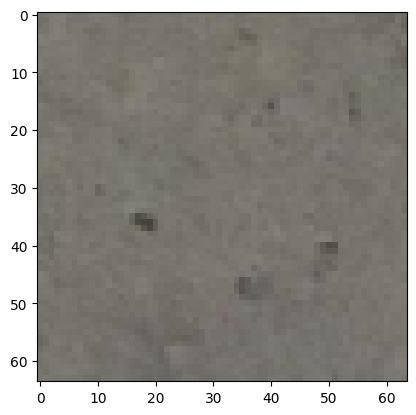

In [ ]:
plt.imshow(x_train[0])

64x64 로 리사이징 된 것을 확인하였습니다.

In [ ]:
# 공식문서 참고 / 구현

latent_dim = 1024

# encoder
encoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(64, 64, 3)),
    Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu), # relu
    Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
])

# decoder
decoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(latent_dim,)), #
    Dense(4 * 4 * 128),
    Reshape(target_shape=(4, 4, 128)),
    Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(32, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid') # 64x64, sigmoid
])


od = OutlierVAE(
    threshold=.005,
    score_type='mse',
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=latent_dim,
)

In [ ]:
encoder_net.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 128)       131200    
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 512)         1049088   
                                                                 
Total params: 1183424 (4.51 MB)
Trainable params: 1183424 (4.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
decoder_net.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 2048)              2099200   
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_12 (Conv2  (None, 8, 8, 256)         524544    
 DTranspose)                                                     
                                                                 
 conv2d_transpose_13 (Conv2  (None, 16, 16, 64)        262208    
 DTranspose)                                                     
                                                                 
 conv2d_transpose_14 (Conv2  (None, 32, 32, 32)        32800     
 DTranspose)                                                     
                                                      

원래 4만장을 조사해야 하나 테스트용이므로 1000장 분석

In [ ]:
od.fit(
    x_train,
    epochs=30,
    verbose=True
)

16/16 [=] - 2s 131ms/step - loss_ma: -21806.0266


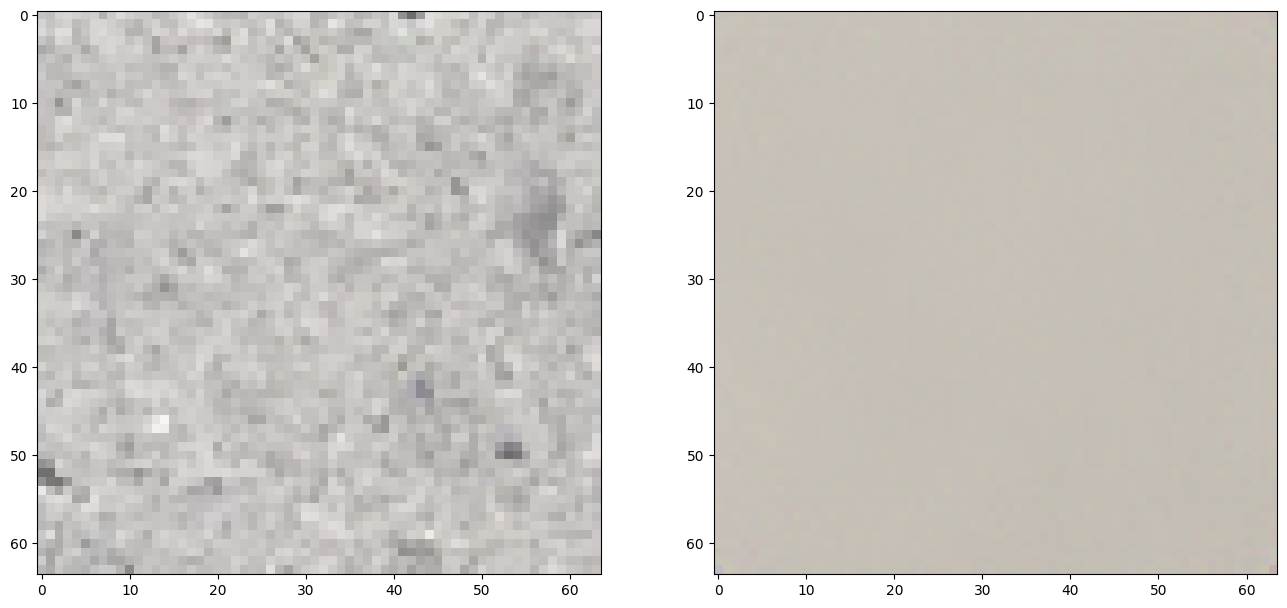

In [ ]:
idx = 12
x = x_train[idx].reshape(1, 64, 64, 3)
x_recon = od.vae(x).numpy()

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

axes[0].imshow(x.squeeze())
axes[1].imshow(x_recon.squeeze())

오른쪽이 reconstruction

왼쪽 사진을 받고 오른쪽 정상 이미지 사진을 그린다.

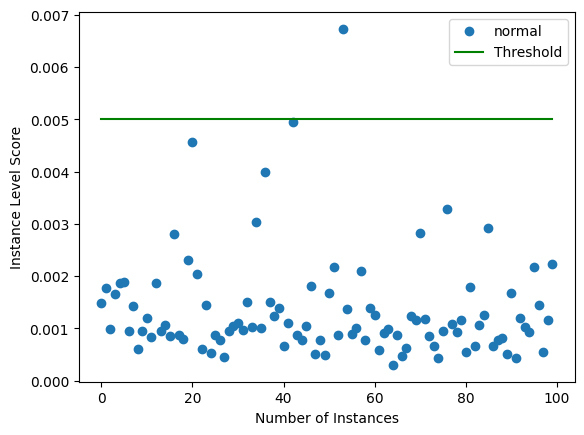

In [ ]:
# val 데이터셋 예측 수행

od_preds = od.predict(
    x_val,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_val.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

슬레시보드 선 = 임계치

100개 이미지 중에 99개가 정상 1개가 이상치로 판별 할 수 있다.

원래 이미지에서 검증셋 100개의 차이를 구한다.

즉 한개의 이상치는 outlier로 볼 수 있다.

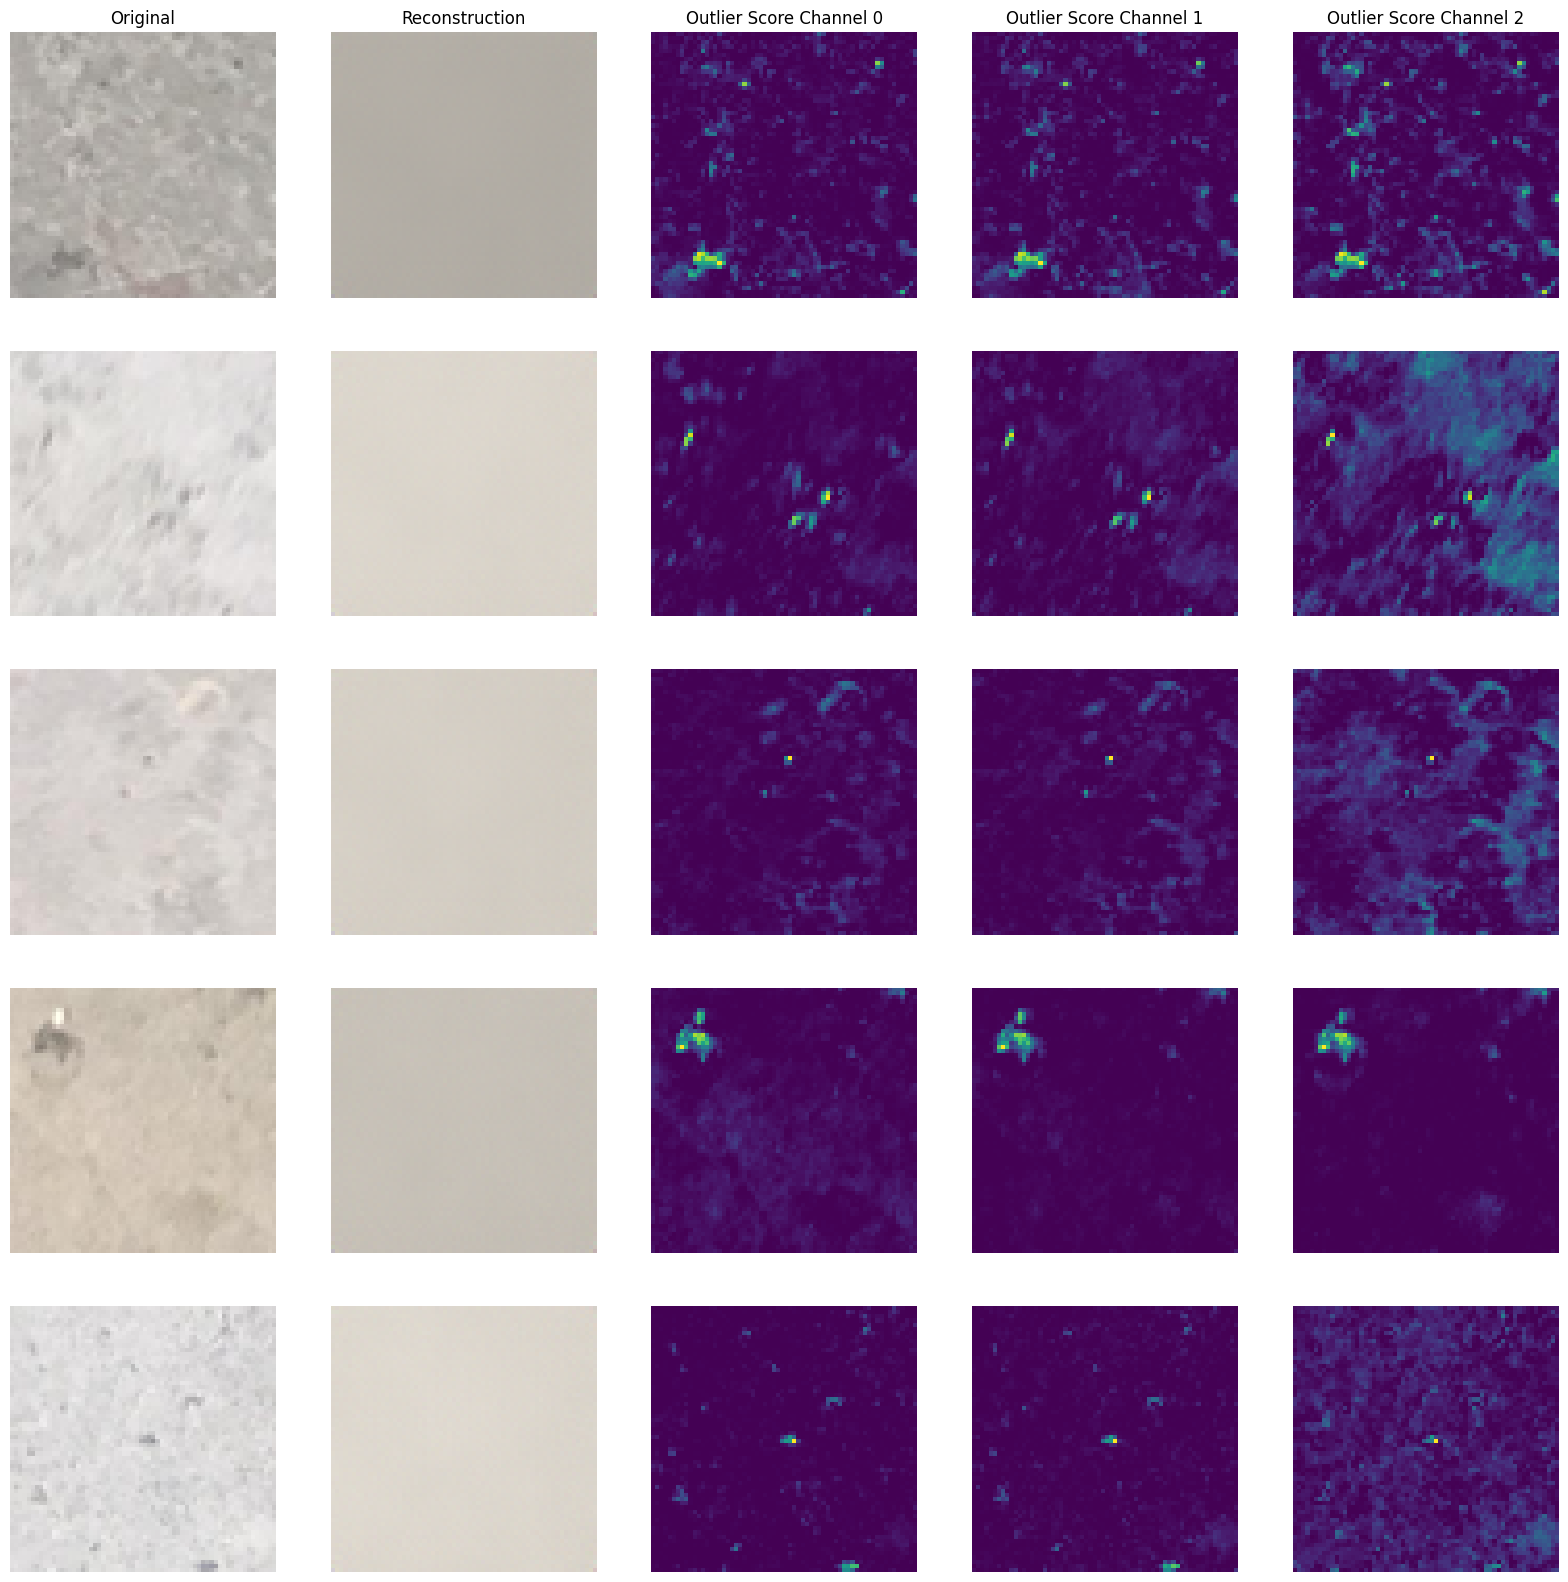

In [ ]:
x_recon = od.vae(x_val).numpy()

plot_feature_outlier_image(
    od_preds,
    x_val,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False
)

# 1.원본 이미지
# 2.원본이미지를 재구성해서 만들어낸 것
# 1번에서 2번을 뺀 것이 보라색 화면이다.
# 빼니까 도드라지는 부분으로 이상치를 판별한다.

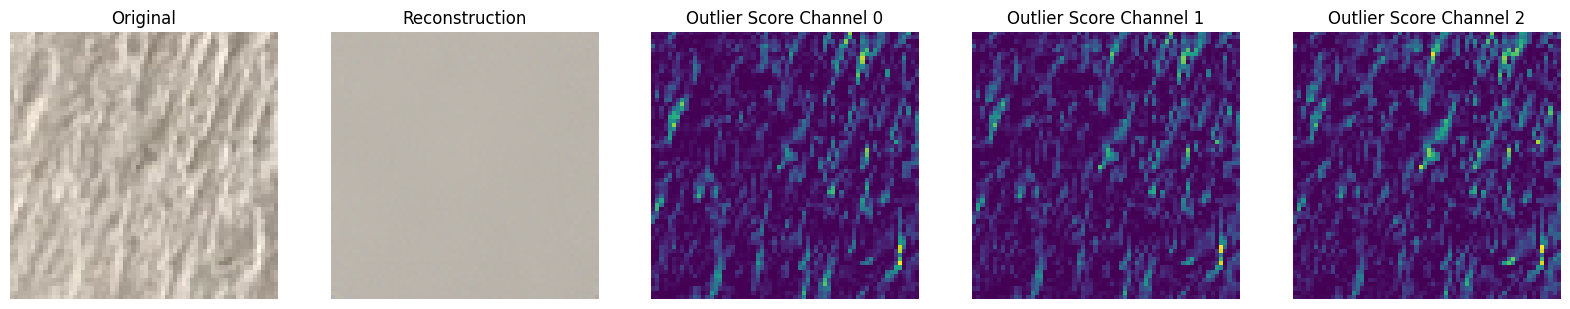

In [ ]:
plot_feature_outlier_image(
    od_preds,
    x_val,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=True #True 크랙, False 정상
)

# 검증셋 데이터 중에서 이상치를 추출해본다.

In [ ]:
test_img_list = glob('Positive/*.jpg')

x_test = img_to_np(test_img_list[:32])
x_test = x_test.astype(np.float32) / 255.

print(x_test.shape)

(32, 64, 64, 3)


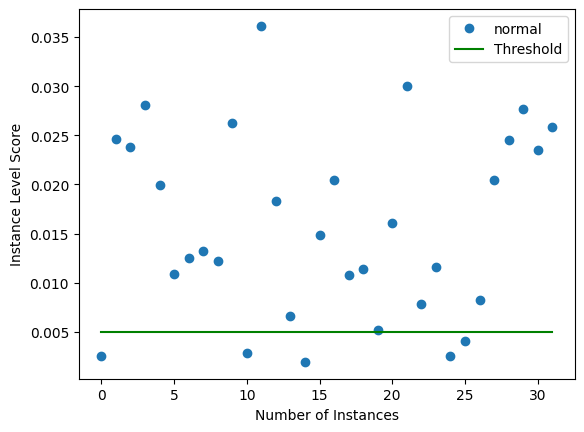

In [ ]:
od_preds = od.predict(
    x_test,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_test.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

# 이상치를 판별하는 그래프를 출력한다. 대략 여러개 나왔다.
# 모델을 더 정교하게 만들려면 임계치를 수정해주어야 한다.

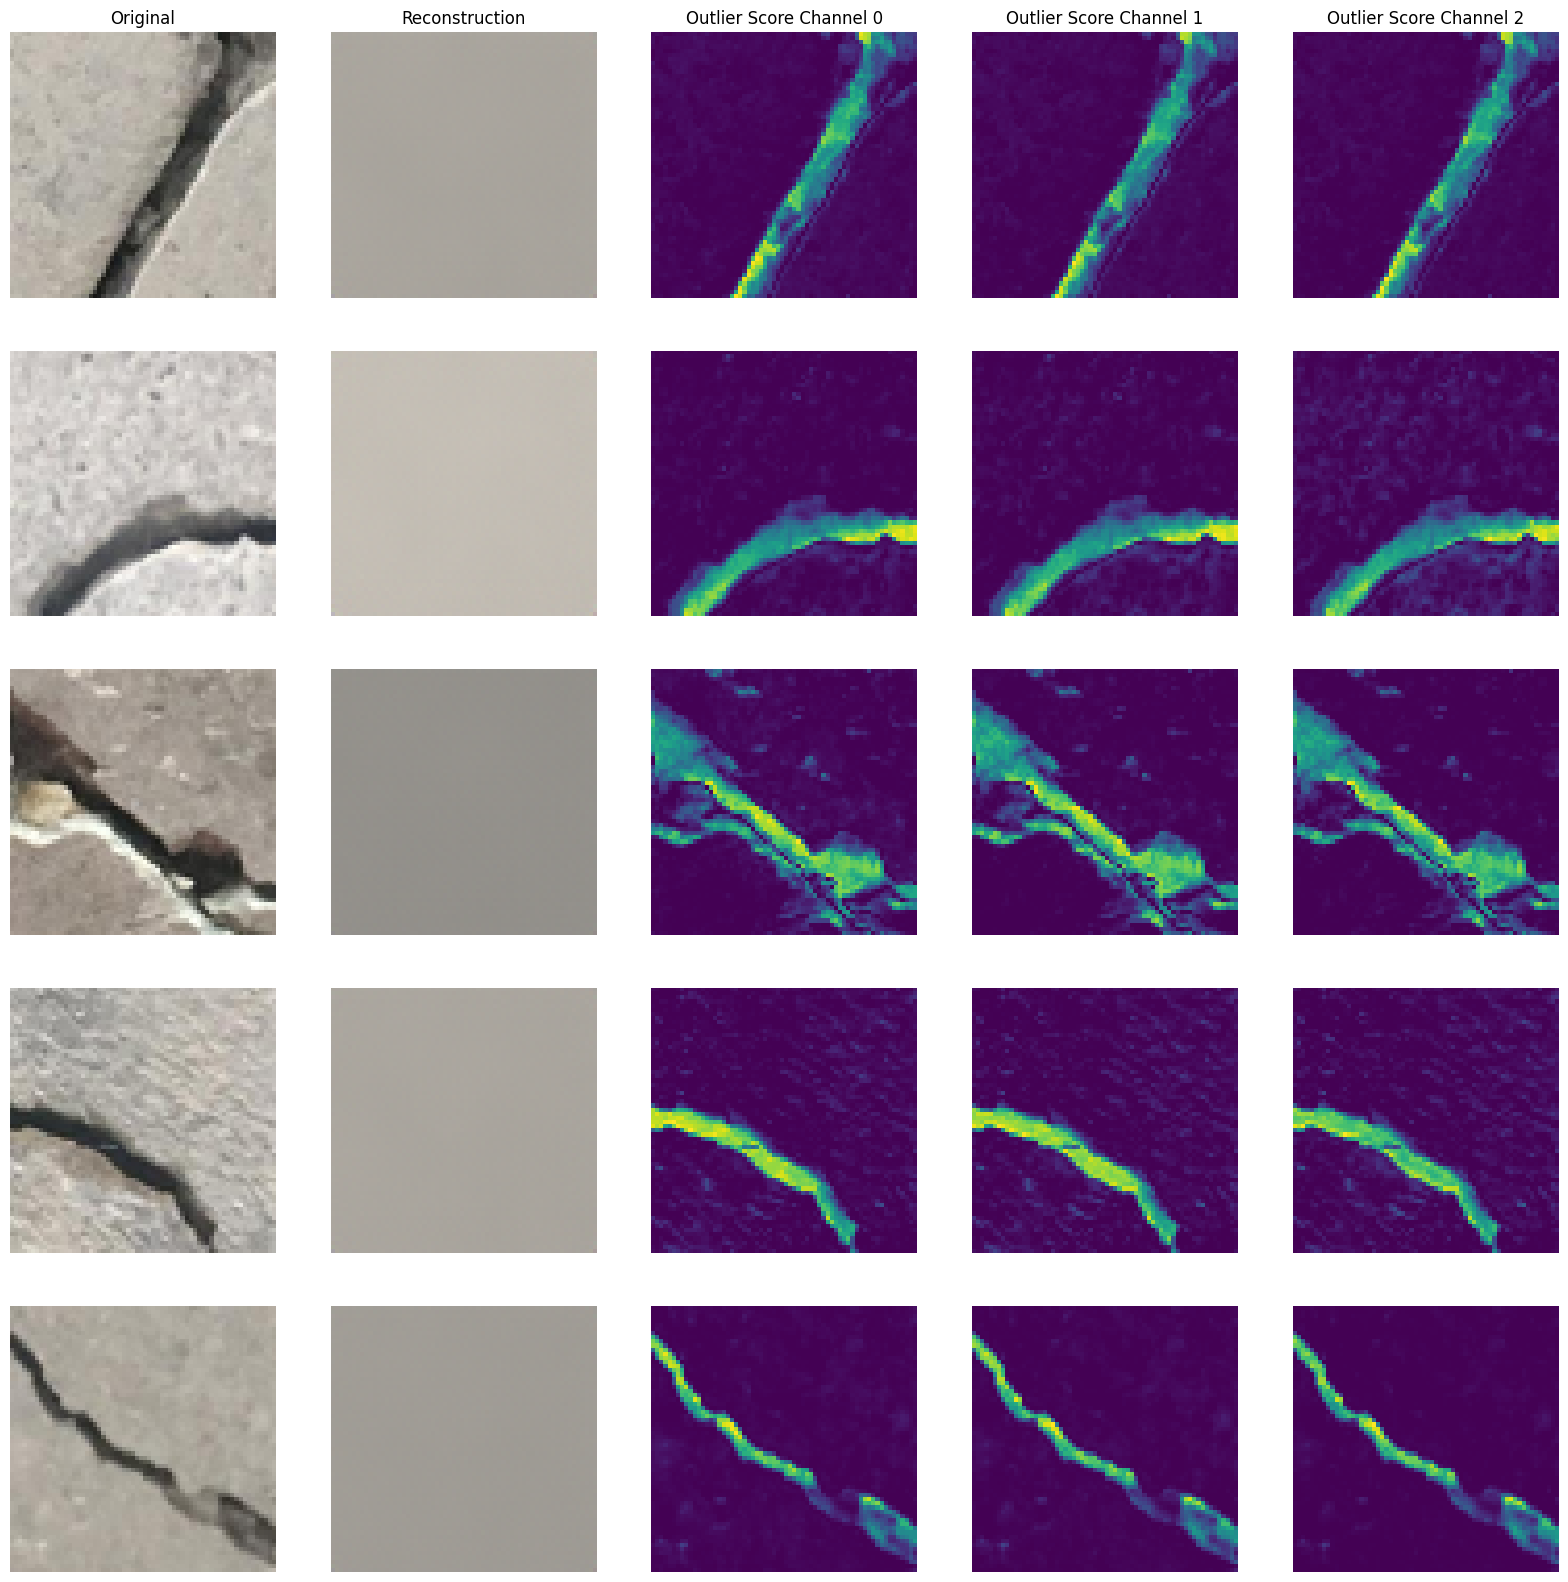

In [ ]:
x_recon = od.vae(x_test).numpy()

plot_feature_outlier_image(
    od_preds,
    x_test,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=True #True 이상치만 강조, False 전체 랜덤 강조
)

In [ ]:
import shutil

# 이동할 파일의 원본 폴더 경로
source_folder = '/content/Negative/*.jpg'

# Google Drive의 대상 폴더 경로
drive_folder = '/content/drive/MyDrive/Dataset/outlier/Negative'

# 원본 폴더의 모든 파일 리스트
file_list = os.listdir(source_folder)

# Google Drive 폴더로 파일 복사
for file_name in file_list:
    # 파일의 전체 경로
    file_path = os.path.join(source_folder, file_name)
    # Google Drive 폴더로 파일 복사
    shutil.copy(file_path, drive_folder)
    print(f'{file_name} 파일을 Google Drive 폴더로 복사했습니다.')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
